In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf

In [4]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading: 100%|██████████| 570/570 [00:00<00:00, 114kB/s]
Downloading: 100%|██████████| 511M/511M [04:32<00:00, 1.97MB/s] 
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 278kB/s]  
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 7.02kB/s]
Downloading: 100%|██████████| 455k/455k [00:01<00:00, 406kB/s]  


In [3]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [6]:
from sklearn.model_selection import train_test_split
X,y = df[TEXT_COLUMN_NAME],df[LABEL_COLUMN_NAME]
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.30, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.50, random_state=42)

In [7]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [9]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(pd.DataFrame({DATA_COLUMN:x_train,LABEL_COLUMN:y_train}), pd.DataFrame({DATA_COLUMN:x_test,LABEL_COLUMN:y_test}), DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
    135/Unknown - 43891s 327s/step - loss: 0.3408 - accuracy: 0.8523

## Word2Vec with CNN
Each word will tranform by pretrained model to vector in size 300 so each instance is atually a matrix

In [1]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"

In [4]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [23]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [1]:
import gensim
#glove-twitter-200
# glove_vectors = gensim.downloader.load('word2vec-google-news-300')
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)



In [5]:
import re
MAX_NUMBER_OF_WORDS = 20000
ENCODE_SIZE = 300
# import inflect
#     try:
#         p = inflect.engine()
#         word = p.number_to_words(word)
#     except:
#         pass
def get_vector(word):
    try:
        return word2vec.get_vector(word)
    except:
        pass
    return np.zeros((300,))

In [24]:
def precoess_row(text):
    vec = np.array([get_vector(word) for word in nltk.word_tokenize(re.sub(r'\d+', '', text))])
    if vec.shape[0] > MAX_NUMBER_OF_WORDS:
        vec = vec[:MAX_NUMBER_OF_WORDS,:]
    else:
        vec = np.vstack((vec,np.zeros((MAX_NUMBER_OF_WORDS-vec.shape[0],ENCODE_SIZE))))
    return vec
# df["Text"] = 
df["Text_vector"] = df["Text"].swifter.apply(precoess_row)

(20006, 300)


(20000, 300)

In [ ]:
from sklearn.model_selection import train_test_split
X,y = df['Text_vector'],df[LABEL_COLUMN_NAME]
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.30, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.50, random_state=42)

In [32]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,MaxPool1D,Flatten,Conv2D,Dropout,MaxPooling2D
model = Sequential()
model.add(Conv2D(10,(5,1), use_bias=True,padding="valid",input_shape=(2000,300,1)))
model.add(MaxPooling2D(pool_size=(5,1),padding='valid'))
model.add(Conv2D(1,(10,1), use_bias=True,padding="valid",input_shape=(2000,300,1)))
model.add(MaxPooling2D(pool_size=(10,1),padding='valid'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 1996, 300, 10)     60        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 399, 300, 10)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 390, 300, 1)       101       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 300, 1)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 300, 1)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 11700)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)             

### Doc2Vec With FF

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

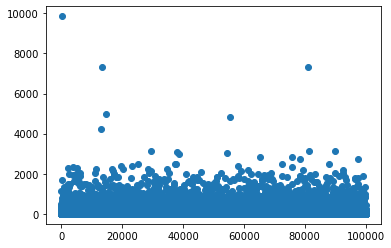

In [62]:
plt.scatter(list(range(df.shape[0])),df["Text"].swifter.apply(lambda text: len(nltk.word_tokenize(text))).values)

In [5]:
doc2vec_model = Doc2Vec([TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)], vector_size=80, window=20, min_count=1, workers=NUM_WORKERS)
stop_words = set(nltk.corpus.stopwords.words("english"))
X = df[TEXT_COLUMN_NAME].swifter.apply(lambda text : doc2vec_model.infer_vector([word for word in nltk.word_tokenize(text) if word not in stop_words]))
y = df[LABEL_COLUMN_NAME]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

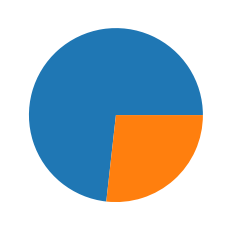

In [9]:
plt.pie(y.value_counts())
weights = (1-y.value_counts()/y.size)*100

In [10]:
weights

0.0    26.771
1.0    73.229
Name: oh_label, dtype: float64

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=1)
x_train = np.expand_dims(np.stack(x_train),axis=2)
x_test = np.expand_dims(np.stack(x_test),axis=2)

In [35]:
x_train.squeeze().shape

(70000, 80)

In [45]:
# strategy = tf.distribute.MirroredStrategy()
model = Sequential()
model.add(Dense(15, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 76, 10)            60        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 25, 10)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 15)                3765      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 16        
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(x_train,y_train,batch_size=200,epochs=500,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[])

Epoch 1/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.4070 - recall_14: 0.6845 - precision_14: 0.2647 - val_loss: 0.6925 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 2/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1717 - accuracy: 0.5173 - recall_14: 0.4607 - precision_14: 0.2670 - val_loss: 0.6937 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 3/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1720 - accuracy: 0.5468 - recall_14: 0.3837 - precision_14: 0.2625 - val_loss: 0.6929 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 4/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1712 - accuracy: 0.3475 - recall_14: 0.8320 - precision_14: 0.2681 - val_loss: 0.6916 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 5/500
333/333 [===

Epoch 35/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.4859 - recall_14: 0.5201 - precision_14: 0.2651 - val_loss: 0.6936 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 36/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.4185 - recall_14: 0.6666 - precision_14: 0.2659 - val_loss: 0.6928 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 37/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.6718 - recall_14: 0.1227 - precision_14: 0.2598 - val_loss: 0.6928 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 38/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.5446 - recall_14: 0.4020 - precision_14: 0.2669 - val_loss: 0.6928 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 39/500
333/333

Epoch 69/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1712 - accuracy: 0.4578 - recall_14: 0.5940 - precision_14: 0.2682 - val_loss: 0.6909 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 70/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1719 - accuracy: 0.5752 - recall_14: 0.3300 - precision_14: 0.2644 - val_loss: 0.6923 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 71/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.5425 - recall_14: 0.4037 - precision_14: 0.2660 - val_loss: 0.6922 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 72/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.5786 - recall_14: 0.3307 - precision_14: 0.2675 - val_loss: 0.6921 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 73/500

333/333 [==============================] - 1s 3ms/step - loss: 27.1714 - accuracy: 0.5887 - recall_14: 0.3018 - precision_14: 0.2645 - val_loss: 0.6936 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 136/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1718 - accuracy: 0.4699 - recall_14: 0.5576 - precision_14: 0.2659 - val_loss: 0.6933 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 137/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.5571 - recall_14: 0.3691 - precision_14: 0.2648 - val_loss: 0.6929 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 138/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.4698 - recall_14: 0.5631 - precision_14: 0.2671 - val_loss: 0.6937 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 139/500
333/333 [=======================

Epoch 202/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.6088 - recall_14: 0.2579 - precision_14: 0.2637 - val_loss: 0.6922 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 203/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1717 - accuracy: 0.5142 - recall_14: 0.4577 - precision_14: 0.2644 - val_loss: 0.6923 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 204/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1714 - accuracy: 0.5058 - recall_14: 0.4841 - precision_14: 0.2667 - val_loss: 0.6931 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 205/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1714 - accuracy: 0.4193 - recall_14: 0.6739 - precision_14: 0.2676 - val_loss: 0.6913 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 20

333/333 [==============================] - 1s 3ms/step - loss: 27.1717 - accuracy: 0.5838 - recall_14: 0.3123 - precision_14: 0.2645 - val_loss: 0.6929 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 269/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1720 - accuracy: 0.5018 - recall_14: 0.4907 - precision_14: 0.2662 - val_loss: 0.6928 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 270/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.6506 - recall_14: 0.1673 - precision_14: 0.2611 - val_loss: 0.6928 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 271/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1718 - accuracy: 0.4943 - recall_14: 0.5047 - precision_14: 0.2657 - val_loss: 0.6928 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 272/500
333/333 

Epoch 302/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1713 - accuracy: 0.5374 - recall_14: 0.4168 - precision_14: 0.2667 - val_loss: 0.6929 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 303/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.4517 - recall_14: 0.5938 - precision_14: 0.2654 - val_loss: 0.6916 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 304/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.5431 - recall_14: 0.4049 - precision_14: 0.2668 - val_loss: 0.6916 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 305/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1714 - accuracy: 0.6692 - recall_14: 0.1319 - precision_14: 0.2637 - val_loss: 0.6935 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 306/500
33

333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.6388 - recall_14: 0.1958 - precision_14: 0.2639 - val_loss: 0.6921 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 369/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1718 - accuracy: 0.6379 - recall_14: 0.1913 - precision_14: 0.2598 - val_loss: 0.6937 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 370/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.6207 - recall_14: 0.2323 - precision_14: 0.2632 - val_loss: 0.6943 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 371/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.4845 - recall_14: 0.5286 - precision_14: 0.2664 - val_loss: 0.6933 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 372/500
333/333 [=======================

Epoch 435/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.5644 - recall_14: 0.3576 - precision_14: 0.2662 - val_loss: 0.6944 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 436/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1717 - accuracy: 0.5347 - recall_14: 0.4201 - precision_14: 0.2659 - val_loss: 0.6939 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 437/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1720 - accuracy: 0.5513 - recall_14: 0.3780 - precision_14: 0.2637 - val_loss: 0.6934 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 438/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.4837 - recall_14: 0.5187 - precision_14: 0.2636 - val_loss: 0.6930 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 439/500
333/333 [=========

Epoch 469/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1716 - accuracy: 0.5630 - recall_14: 0.3522 - precision_14: 0.2632 - val_loss: 0.6923 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 470/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1715 - accuracy: 0.4658 - recall_14: 0.5752 - precision_14: 0.2679 - val_loss: 0.6913 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 471/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1713 - accuracy: 0.5824 - recall_14: 0.3238 - precision_14: 0.2679 - val_loss: 0.6941 - val_accuracy: 0.2749 - val_recall_14: 1.0000 - val_precision_14: 0.2749
Epoch 472/500
333/333 [==============================] - 1s 3ms/step - loss: 27.1712 - accuracy: 0.3404 - recall_14: 0.8467 - precision_14: 0.2680 - val_loss: 0.6917 - val_accuracy: 0.7251 - val_recall_14: 0.0000e+00 - val_precision_14: 0.0000e+00
Epoch 473/500
33

In [39]:
model1 = Sequential()
model1.add(Dense(40, activation="relu",input_shape=(80,)))
model1.add(Dense(10, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 3,661
Trainable params: 3,661
Non-trainable params: 0
_________________________________________________________________


In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model1.fit(x_train.squeeze(),y_train,batch_size=200,epochs=100,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/100
333/333 [==============================] - 1s 2ms/step - loss: 27.1780 - accuracy: 0.4940 - recall_8: 0.5097 - precision_8: 0.2667 - val_loss: 0.6869 - val_accuracy: 0.7251 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 2/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1747 - accuracy: 0.5268 - recall_8: 0.4475 - precision_8: 0.2690 - val_loss: 0.6868 - val_accuracy: 0.7251 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 3/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1748 - accuracy: 0.5074 - recall_8: 0.4786 - precision_8: 0.2661 - val_loss: 0.6852 - val_accuracy: 0.7251 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 4/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1753 - accuracy: 0.4956 - recall_8: 0.5072 - precision_8: 0.2670 - val_loss: 0.6850 - val_accuracy: 0.7251 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 5/100
333/333 [===========

Epoch 35/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1767 - accuracy: 0.5244 - recall_8: 0.4401 - precision_8: 0.2654 - val_loss: 0.6932 - val_accuracy: 0.2749 - val_recall_8: 1.0000 - val_precision_8: 0.2749
Epoch 36/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1757 - accuracy: 0.5214 - recall_8: 0.4401 - precision_8: 0.2636 - val_loss: 0.6934 - val_accuracy: 0.2749 - val_recall_8: 1.0000 - val_precision_8: 0.2749
Epoch 37/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1728 - accuracy: 0.5403 - recall_8: 0.4193 - precision_8: 0.2693 - val_loss: 0.7085 - val_accuracy: 0.2749 - val_recall_8: 1.0000 - val_precision_8: 0.2749
Epoch 38/100
333/333 [==============================] - 0s 1ms/step - loss: 27.1774 - accuracy: 0.4618 - recall_8: 0.5762 - precision_8: 0.2662 - val_loss: 0.6933 - val_accuracy: 0.2749 - val_recall_8: 1.0000 - val_precision_8: 0.2749
Epoch 39/100
333/333 [==============================] - 0s 1

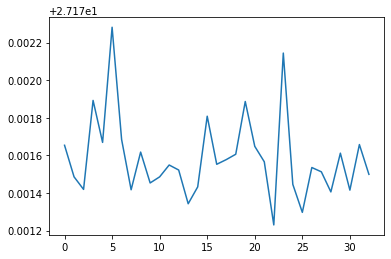

In [28]:
plt.plot(history.history['loss'])

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
max_words = 2200
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df[TEXT_COLUMN_NAME])
sequences = tokenizer.texts_to_sequences(df[TEXT_COLUMN_NAME])
X = pad_sequences(sequences, maxlen=max_len)
y = df[LABEL_COLUMN_NAME]

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=1)

In [58]:
model = Sequential()
model.add(Bidirectional(LSTM(48,recurrent_dropout=0.5),input_shape=(200,1)))
model.add(Dense(24, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 96)                19200     
_________________________________________________________________
dense_37 (Dense)             (None, 24)                2328      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 25        
Total params: 21,553
Trainable params: 21,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(x_train.squeeze(),y_train,batch_size=200,epochs=100,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])